In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import seasonal_decompose, ARIMA, SARIMAX, adfuller

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Bidirectional, TimeDistributed
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
    
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('vaccinations.csv')
df.head()

location iso_code        date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG  2021-02-22                 0.0                0.0   
1  Afghanistan      AFG  2021-02-23                 NaN                NaN   
2  Afghanistan      AFG  2021-02-24                 NaN                NaN   
3  Afghanistan      AFG  2021-02-25                 NaN                NaN   
4  Afghanistan      AFG  2021-02-26                 NaN                NaN   

   people_fully_vaccinated  total_boosters  daily_vaccinations_raw  \
0                      NaN             NaN                     NaN   
1                      NaN             NaN                     NaN   
2                      NaN             NaN                     NaN   
3                      NaN             NaN                     NaN   
4                      NaN             NaN                     NaN   

   daily_vaccinations  total_vaccinations_per_hundred  \
0                 NaN                             0.0   
1              1367.0                             NaN   
2              1367.0                             NaN   
3              1367.0                             NaN   
4              1367.0                             NaN   

   people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  \
0                            0.0                                  NaN   
1                            NaN                                  NaN   
2                            NaN                                  NaN   
3                            NaN                                  NaN   
4                            NaN                                  NaN   

   total_boosters_per_hundred  daily_vaccinations_per_million  \
0                         NaN                             NaN   
1                         NaN                            34.0   
2                         NaN                            34.0   
3                         NaN                            34.0   
4                         NaN                            34.0   

   daily_people_vaccinated  daily_people_vaccinated_per_hundred  
0                      NaN                                  NaN  
1                   1367.0                                0.003  
2                   1367.0                                0.003  
3                   1367.0                                0.003  
4                   1367.0                                0.003

In [3]:
def check_details(data):
    print('Columns are: ', data.columns, '\n','='*50,
      '\nRows: ', data.shape[0],
      '\nCols: ', data.shape[1], '\n','='*50, '\n', data.dtypes)
    
check_details(df)

Columns are:  Index(['location', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object') 
Rows:  114316 
Cols:  16 
 location                                object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
total_boosters                         float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vacci

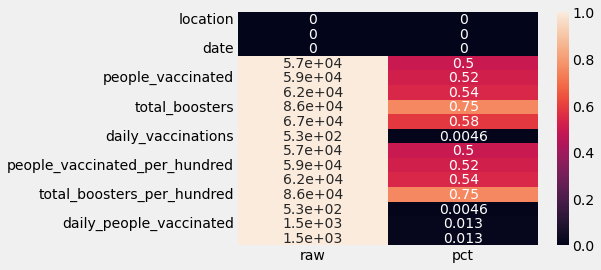

In [4]:
def check_missing_var(data):
    missing_var = pd.DataFrame()
    missing_var['raw'] = data.isnull().sum()
    missing_var['pct'] = data.isnull().sum()/df.shape[0]
    return sns.heatmap(missing_var, annot=True, vmin=0, vmax=1), missing_var

missing_var = check_missing_var(df)[1]

In [5]:
cols = missing_var[missing_var['pct'] < 0.3].index
df2 = df[cols]
df2['date'] = pd.to_datetime(df2['date'])
df2.head()

location iso_code       date  daily_vaccinations  \
0  Afghanistan      AFG 2021-02-22                 NaN   
1  Afghanistan      AFG 2021-02-23              1367.0   
2  Afghanistan      AFG 2021-02-24              1367.0   
3  Afghanistan      AFG 2021-02-25              1367.0   
4  Afghanistan      AFG 2021-02-26              1367.0   

   daily_vaccinations_per_million  daily_people_vaccinated  \
0                             NaN                      NaN   
1                            34.0                   1367.0   
2                            34.0                   1367.0   
3                            34.0                   1367.0   
4                            34.0                   1367.0   

   daily_people_vaccinated_per_hundred  
0                                  NaN  
1                                0.003  
2                                0.003  
3                                0.003  
4                                0.003

In [6]:
check_details(df2)

Columns are:  Index(['location', 'iso_code', 'date', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object') 
Rows:  114316 
Cols:  7 
 location                                       object
iso_code                                       object
date                                   datetime64[ns]
daily_vaccinations                            float64
daily_vaccinations_per_million                float64
daily_people_vaccinated                       float64
daily_people_vaccinated_per_hundred           float64
dtype: object


(<AxesSubplot:>,
                                       raw       pct
 location                                0  0.000000
 iso_code                                0  0.000000
 date                                    0  0.000000
 daily_vaccinations                    531  0.004645
 daily_vaccinations_per_million        531  0.004645
 daily_people_vaccinated              1471  0.012868
 daily_people_vaccinated_per_hundred  1471  0.012868)

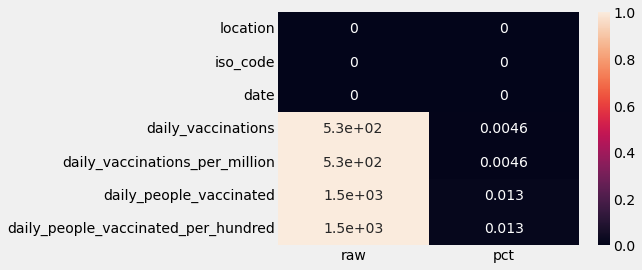

In [7]:
check_missing_var(df2)

# EDA

In [8]:
ph_df = df2[df2['iso_code'] == 'PHL'].reset_index(drop=True)[1:]
ph_df.set_index('date', inplace=True)
ph_df.head()

location iso_code  daily_vaccinations  \
date                                                   
2021-03-01  Philippines      PHL               756.0   
2021-03-02  Philippines      PHL              1396.0   
2021-03-03  Philippines      PHL              2132.0   
2021-03-04  Philippines      PHL              2500.0   
2021-03-05  Philippines      PHL              3514.0   

            daily_vaccinations_per_million  daily_people_vaccinated  \
date                                                                  
2021-03-01                             7.0                    756.0   
2021-03-02                            12.0                   1396.0   
2021-03-03                            19.0                   2132.0   
2021-03-04                            22.0                   2500.0   
2021-03-05                            31.0                   3514.0   

            daily_people_vaccinated_per_hundred  
date                                             
2021-03-01                                0.001  
2021-03-02                                0.001  
2021-03-03                                0.002  
2021-03-04                                0.002  
2021-03-05                                0.003

In [9]:
check_details(ph_df), ph_df.index[0], ph_df.index[-1]

Columns are:  Index(['location', 'iso_code', 'daily_vaccinations',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object') 
Rows:  494 
Cols:  6 
 location                                object
iso_code                                object
daily_vaccinations                     float64
daily_vaccinations_per_million         float64
daily_people_vaccinated                float64
daily_people_vaccinated_per_hundred    float64
dtype: object


(None, Timestamp('2021-03-01 00:00:00'), Timestamp('2022-07-07 00:00:00'))

(<AxesSubplot:>,
                                      raw  pct
 location                               0  0.0
 iso_code                               0  0.0
 daily_vaccinations                     0  0.0
 daily_vaccinations_per_million         0  0.0
 daily_people_vaccinated                0  0.0
 daily_people_vaccinated_per_hundred    0  0.0)

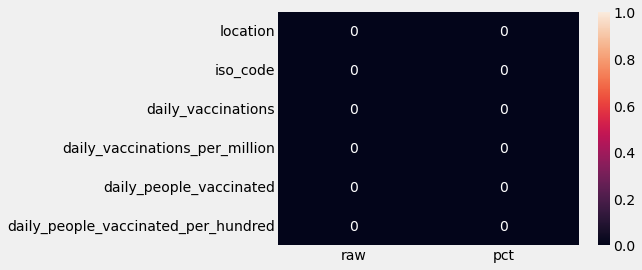

In [10]:
check_missing_var(ph_df)

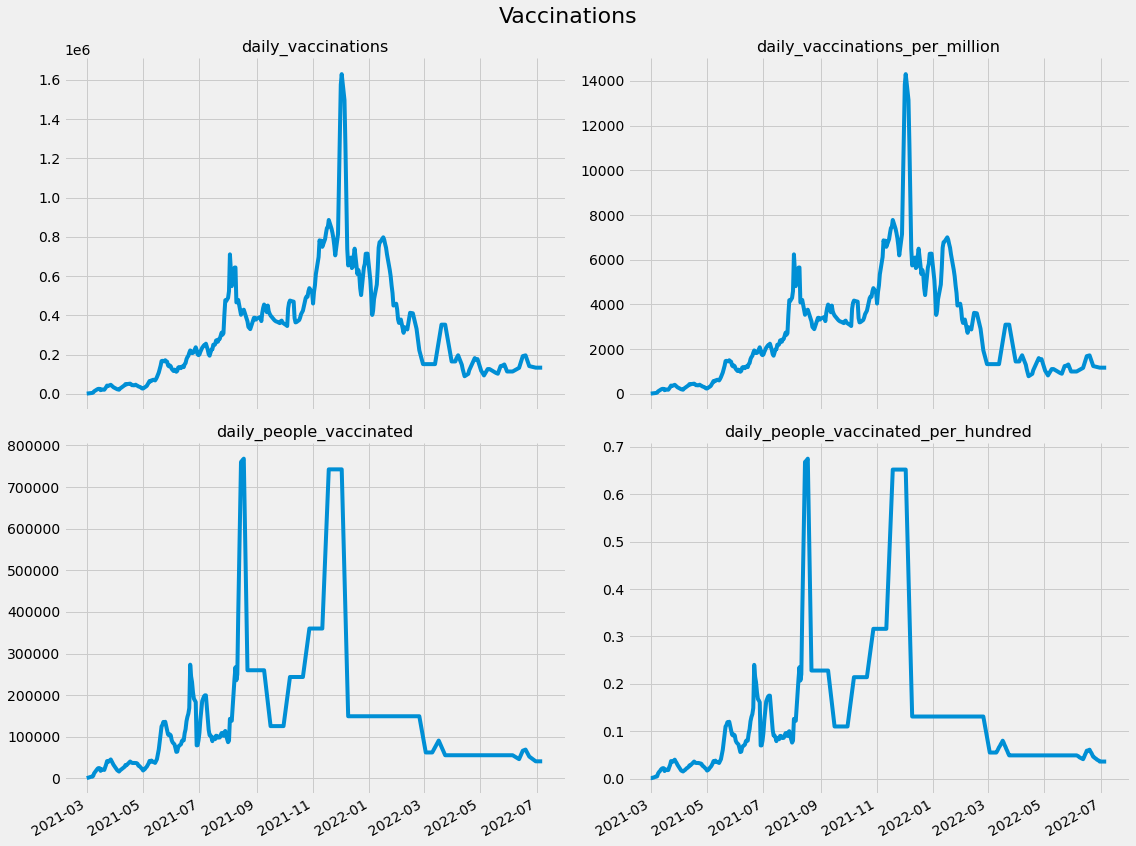

In [11]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
i = 0 
ax = ax.flatten()

fig.suptitle('Vaccinations', fontsize=22)
fig.autofmt_xdate()

for x in ph_df.columns[2:]:
    ax[i].plot(ph_df[x])
    ax[i].set_title(x, fontsize=16)
    i += 1
    
plt.tight_layout()
sns.despine()

In [91]:
ph_df_clean = ph_df[['daily_vaccinations', 'daily_people_vaccinated']]
ph_df_clean

daily_vaccinations  daily_people_vaccinated
date                                                   
2021-03-01               756.0                    756.0
2021-03-02              1396.0                   1396.0
2021-03-03              2132.0                   2132.0
2021-03-04              2500.0                   2500.0
2021-03-05              3514.0                   3514.0
...                        ...                      ...
2022-07-03            133007.0                  41140.0
2022-07-04            133007.0                  41140.0
2022-07-05            133007.0                  41140.0
2022-07-06            133007.0                  41140.0
2022-07-07            133007.0                  41140.0

[494 rows x 2 columns]

# Outlier Detection

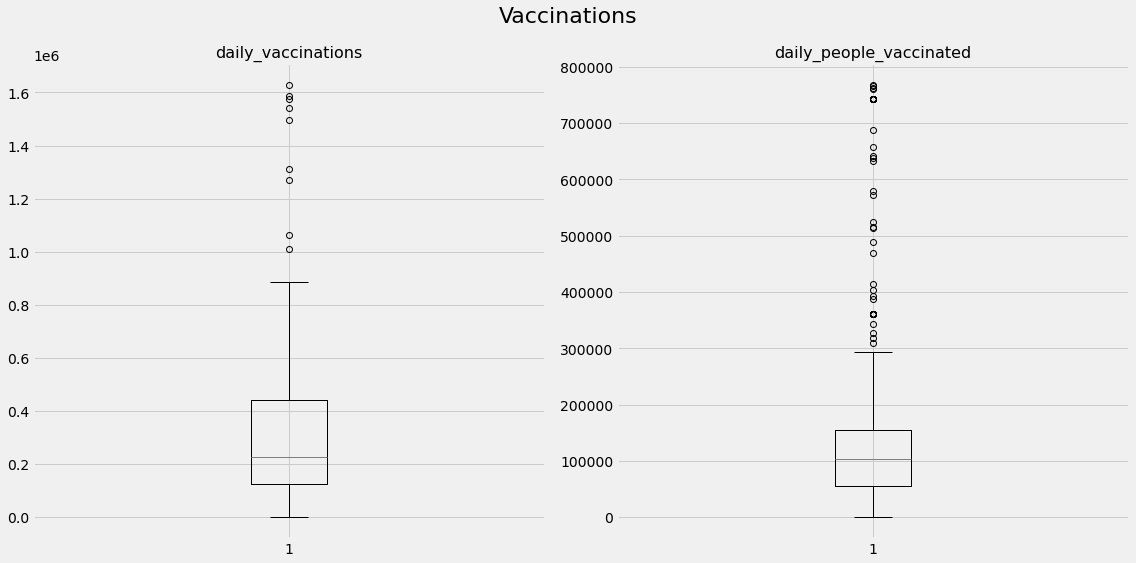

In [78]:
plt.figure(figsize=(16,8)).suptitle('Vaccinations', fontsize=22)

plt.subplot(1, 2, 1).set_title('daily_vaccinations', fontsize=16)
plt.boxplot(ph_df_clean['daily_vaccinations'])


plt.subplot(1, 2, 2).set_title('daily_people_vaccinated', fontsize=16)
plt.boxplot(ph_df_clean['daily_people_vaccinated'])

plt.tight_layout()
plt.show()

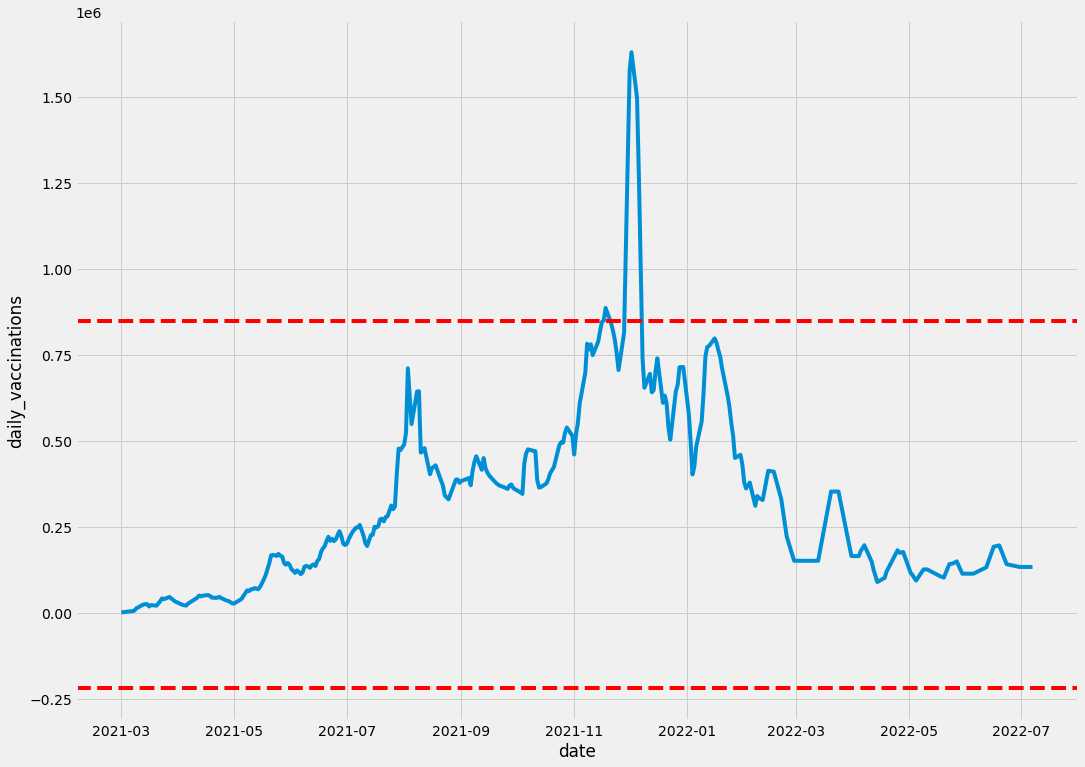

In [92]:
plt.figure(figsize=(16,12))
sns.lineplot(ph_df_clean.index, ph_df_clean.daily_vaccinations)
upl = ph_df_clean.daily_vaccinations.mean() + (ph_df_clean.daily_vaccinations.std() * 2)
lpl = ph_df_clean.daily_vaccinations.mean() - (ph_df_clean.daily_vaccinations.std() * 2)
plt.axhline(y=upl, ls='--', c='r')
plt.axhline(y=lpl, ls='--', c='r')

# Aggregations

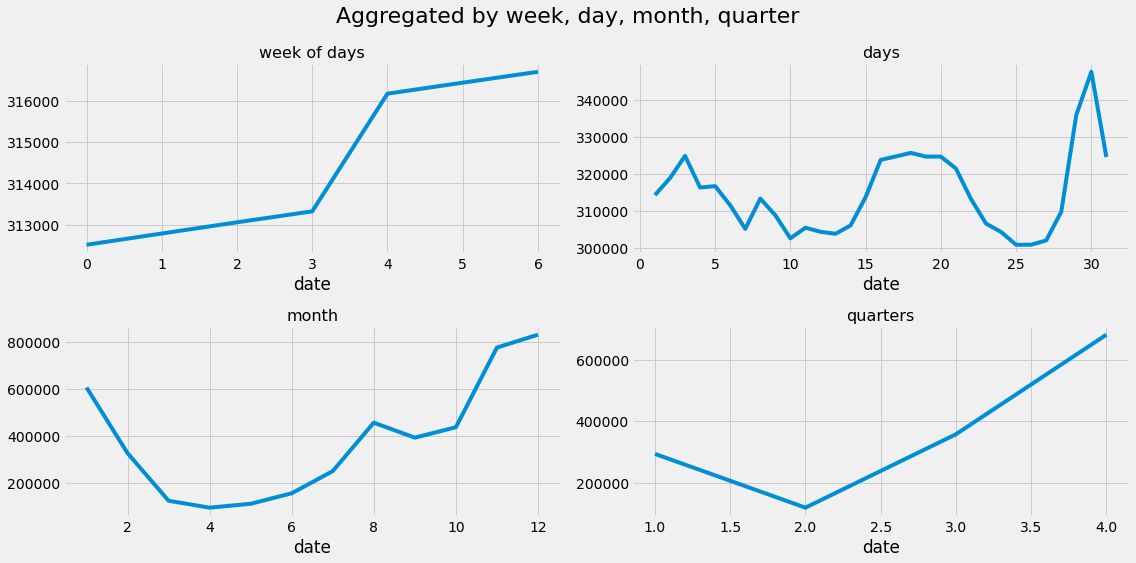

In [14]:
to_plot1 = ph_df_clean.groupby(ph_df_clean.index.weekday).mean()
to_plot2 = ph_df_clean.groupby(ph_df_clean.index.day).mean()
to_plot3 = ph_df_clean.groupby(ph_df_clean.index.month).mean()
to_plot4 = ph_df_clean.groupby(ph_df_clean.index.quarter).mean()

plt.figure(figsize=(16,8)).suptitle('Aggregated by week, day, month, quarter', fontsize=22)

# Weekdays
plt.subplot(2, 2, 1).set_title('week of days', fontsize=16)
to_plot1['daily_vaccinations'].plot()

# Days
plt.subplot(2, 2, 2).set_title('days', fontsize=16)
to_plot2['daily_vaccinations'].plot()

# Months
plt.subplot(2, 2, 3).set_title('month', fontsize=16)
to_plot3['daily_vaccinations'].plot()

# Quarters
plt.subplot(2, 2, 4).set_title('quarters', fontsize=16)
to_plot4['daily_vaccinations'].plot()

plt.tight_layout()

In [15]:
ph_df_clean['pct'] = ph_df_clean['daily_vaccinations'].pct_change()*100
ph_df_clean[['daily_vaccinations', 'pct']]

daily_vaccinations        pct
date                                     
2021-03-01               756.0        NaN
2021-03-02              1396.0  84.656085
2021-03-03              2132.0  52.722063
2021-03-04              2500.0  17.260788
2021-03-05              3514.0  40.560000
...                        ...        ...
2022-07-03            133007.0   0.000000
2022-07-04            133007.0   0.000000
2022-07-05            133007.0   0.000000
2022-07-06            133007.0   0.000000
2022-07-07            133007.0   0.000000

[494 rows x 2 columns]

<AxesSubplot:xlabel='date'>

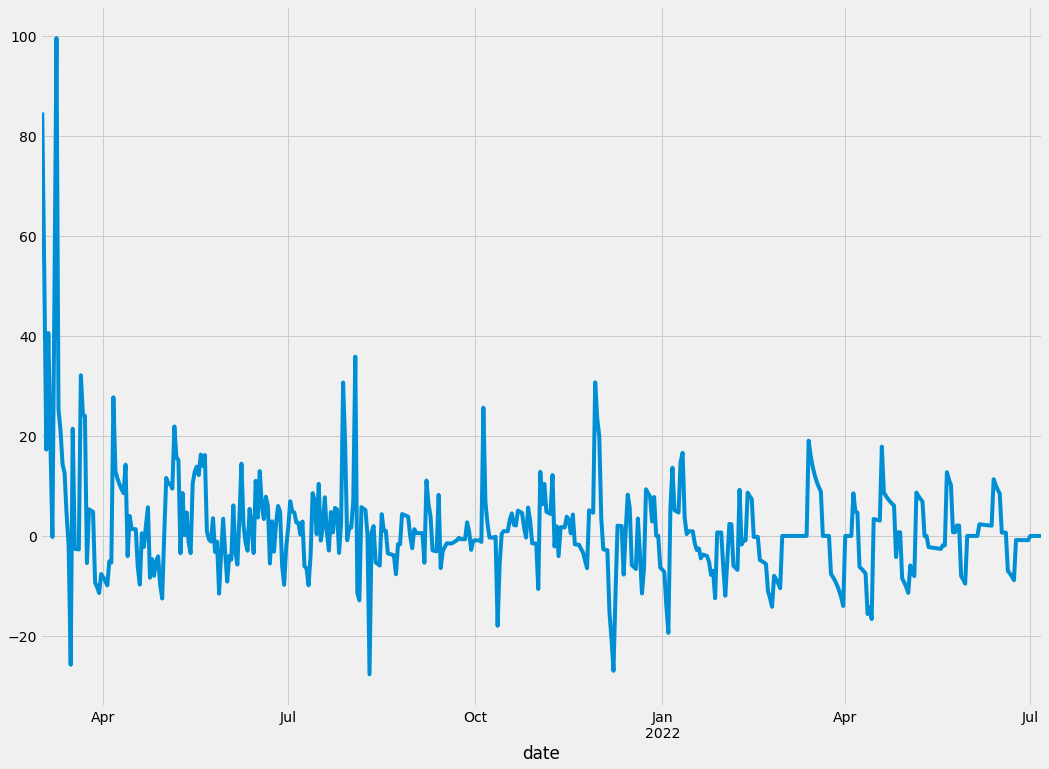

In [16]:
ph_df_clean['pct'].plot(figsize=(16,12))

In [17]:
ph_df_final = ph_df_clean['daily_vaccinations']
ph_df_final

date
2021-03-01       756.0
2021-03-02      1396.0
2021-03-03      2132.0
2021-03-04      2500.0
2021-03-05      3514.0
                ...   
2022-07-03    133007.0
2022-07-04    133007.0
2022-07-05    133007.0
2022-07-06    133007.0
2022-07-07    133007.0
Name: daily_vaccinations, Length: 494, dtype: float64

# Seasonality

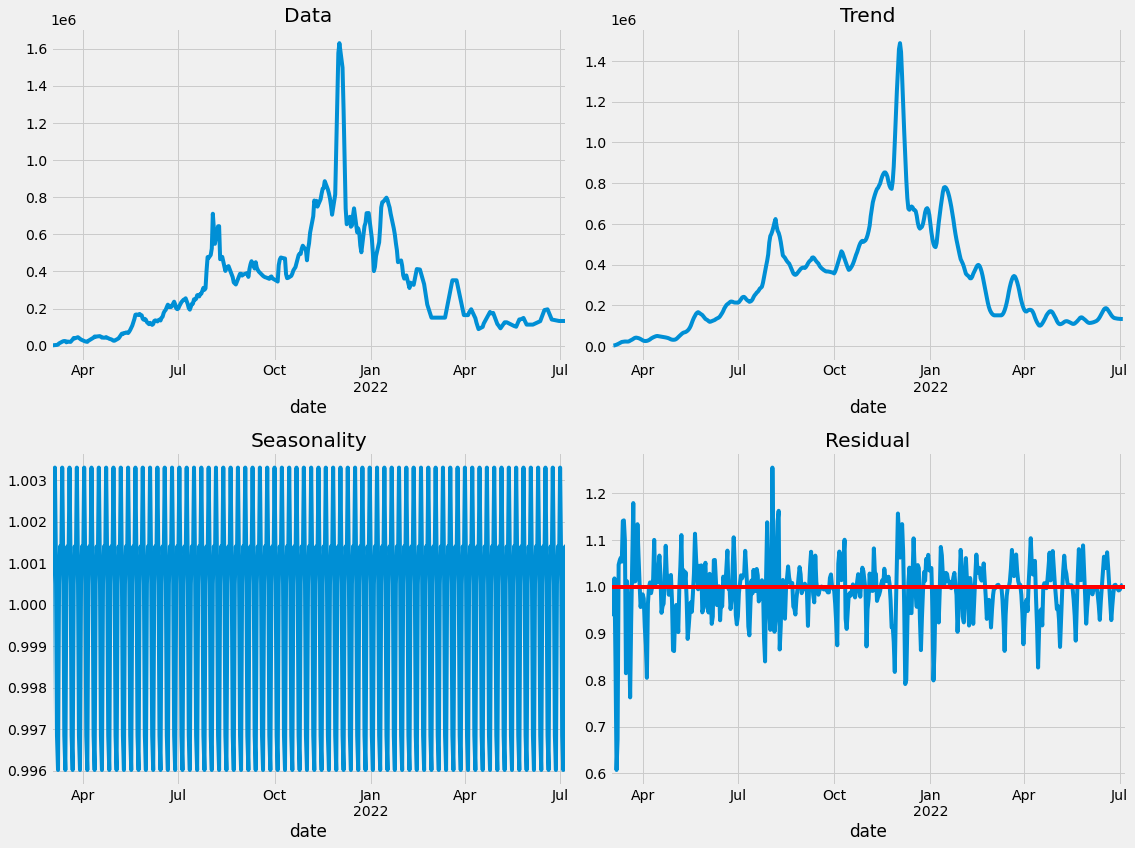

In [18]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1).set_title('Data')
seasonal_decompose(ph_df_final, model='multiplicative').observed.plot()

plt.subplot(2, 2, 2).set_title('Trend')
seasonal_decompose(ph_df_final, model='multiplicative').trend.plot()

plt.subplot(2, 2, 3).set_title('Seasonality')
seasonal_decompose(ph_df_final, model='multiplicative').seasonal.plot()

plt.subplot(2, 2, 4).set_title('Residual')
seasonal_decompose(ph_df_final, model='multiplicative').resid.plot()
plt.axhline(y=1, c='r')

plt.tight_layout()

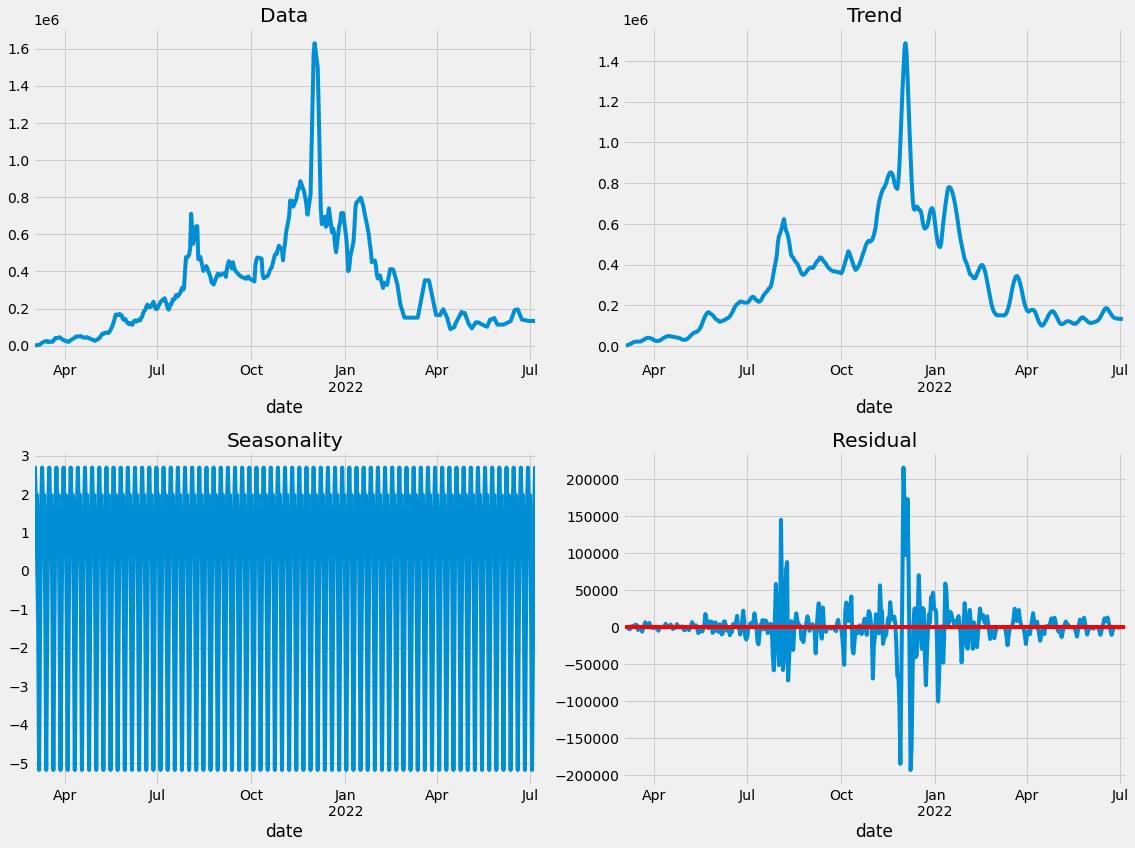

In [19]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1).set_title('Data')
seasonal_decompose(ph_df_final, model='addittive').observed.plot()

plt.subplot(2, 2, 2).set_title('Trend')
seasonal_decompose(ph_df_final, model='addittive').trend.plot()

plt.subplot(2, 2, 3).set_title('Seasonality')
seasonal_decompose(ph_df_final, model='addittive').seasonal.plot()

plt.subplot(2, 2, 4).set_title('Residual')
seasonal_decompose(ph_df_final, model='addittive').resid.plot()
plt.axhline(y=1, c='r')

plt.tight_layout()

In [20]:
ph_df_final.groupby([ph_df_final.index.year, ph_df_final.index.quarter]).mean()

date  date
2021  1        22070.258065
      2       101722.186813
      3       374628.260870
      4       680504.989130
2022  1       387521.422222
      2       137365.197802
      3       133007.000000
Name: daily_vaccinations, dtype: float64

# Stationarity

In [21]:
def adfuller_test(data):
    results = adfuller(data)
    labels = ['T-stat: ', 'P-val: ', '#lags: ']

    for i, x in zip(labels, results[:3]):
        print(i, x)

    print('=' * 30)
    
    if results[1] > 0.05:
        print("Data has a unit root and is non-stationary")
    else:
        print("Data has no unit root and is stationary")

In [22]:
adfuller_test(ph_df_final)

T-stat:  -1.826519194790614
P-val:  0.36737738181198254
#lags:  15
Data has a unit root and is non-stationary


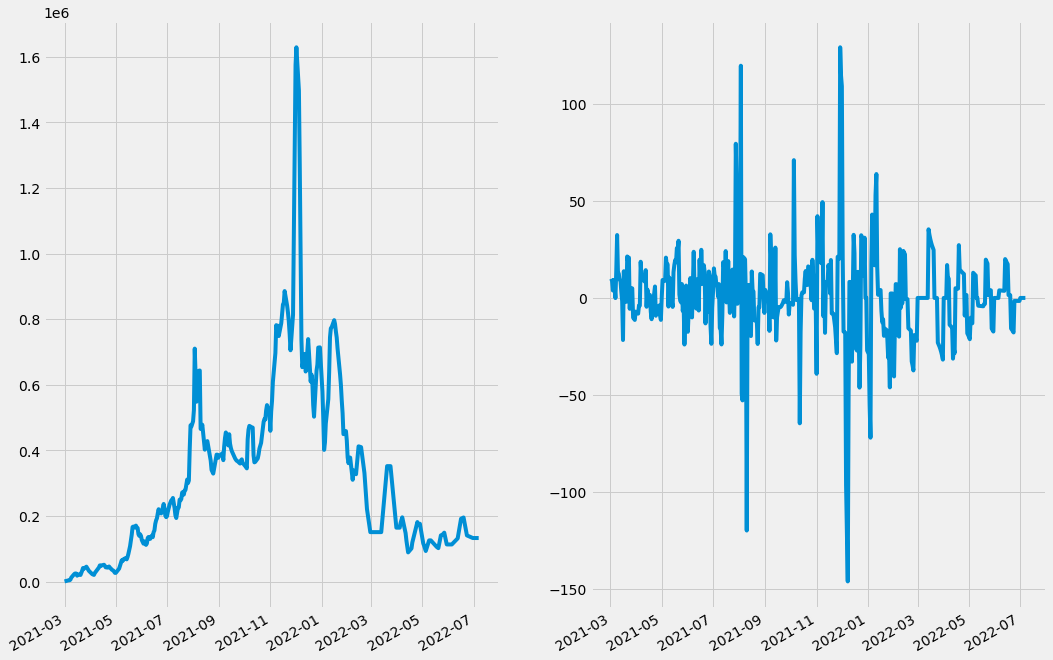

In [23]:
ph_sqrt = np.sqrt(ph_df_final).diff(1).dropna()
fig, ax = plt.subplots(1,2, figsize=(16,12))
fig.autofmt_xdate()

ax[0].plot(ph_df_final)
ax[1].plot(ph_sqrt)

In [24]:
adfuller_test(ph_sqrt)

T-stat:  -6.206210707417296
P-val:  5.649674737453986e-08
#lags:  14
Data has no unit root and is stationary


# Insight

# Correlogram

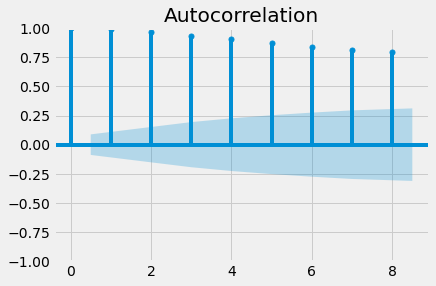

In [25]:
plot_acf(ph_df_final, lags=8).show()

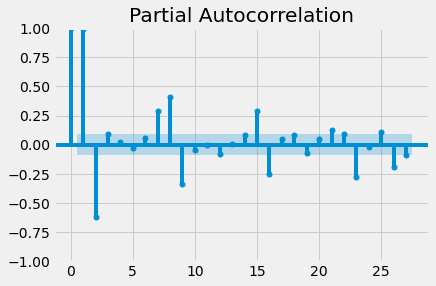

In [26]:
plot_pacf(ph_df_final).show()

0.990035402749104

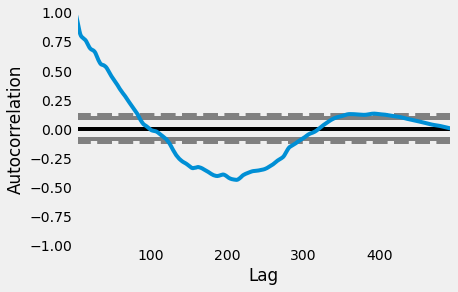

In [27]:
pd.plotting.autocorrelation_plot(ph_df_final)
ph_df_final.autocorr()

# Machine Learning Approach

In [28]:
data = ph_df_clean.copy()
data['month'] = data.index.month
data['day'] = data.index.day
data.reset_index(inplace=True, drop=True)
data

daily_vaccinations  daily_people_vaccinated        pct  month  day
0                 756.0                    756.0        NaN      3    1
1                1396.0                   1396.0  84.656085      3    2
2                2132.0                   2132.0  52.722063      3    3
3                2500.0                   2500.0  17.260788      3    4
4                3514.0                   3514.0  40.560000      3    5
..                  ...                      ...        ...    ...  ...
489            133007.0                  41140.0   0.000000      7    3
490            133007.0                  41140.0   0.000000      7    4
491            133007.0                  41140.0   0.000000      7    5
492            133007.0                  41140.0   0.000000      7    6
493            133007.0                  41140.0   0.000000      7    7

[494 rows x 5 columns]

In [29]:
data['lag1'] = data.daily_vaccinations.shift(1)
data['lag2'] = data.daily_vaccinations.shift(2)
data['lag3'] = data.daily_vaccinations.shift(3)
data.dropna(inplace=True)

In [30]:
data

daily_vaccinations  daily_people_vaccinated        pct  month  day  \
3                2500.0                   2500.0  17.260788      3    4   
4                3514.0                   3514.0  40.560000      3    5   
5                4190.0                   4190.0  19.237336      3    6   
6                4181.0                   4181.0  -0.214797      3    7   
7                6178.0                   6178.0  47.763693      3    8   
..                  ...                      ...        ...    ...  ...   
489            133007.0                  41140.0   0.000000      7    3   
490            133007.0                  41140.0   0.000000      7    4   
491            133007.0                  41140.0   0.000000      7    5   
492            133007.0                  41140.0   0.000000      7    6   
493            133007.0                  41140.0   0.000000      7    7   

         lag1      lag2      lag3  
3      2132.0    1396.0     756.0  
4      2500.0    2132.0    1396.0  
5      3514.0    2500.0    2132.0  
6      4190.0    3514.0    2500.0  
7      4181.0    4190.0    3514.0  
..        ...       ...       ...  
489  133007.0  133007.0  133007.0  
490  133007.0  133007.0  133007.0  
491  133007.0  133007.0  133007.0  
492  133007.0  133007.0  133007.0  
493  133007.0  133007.0  133007.0  

[491 rows x 8 columns]

<AxesSubplot:>

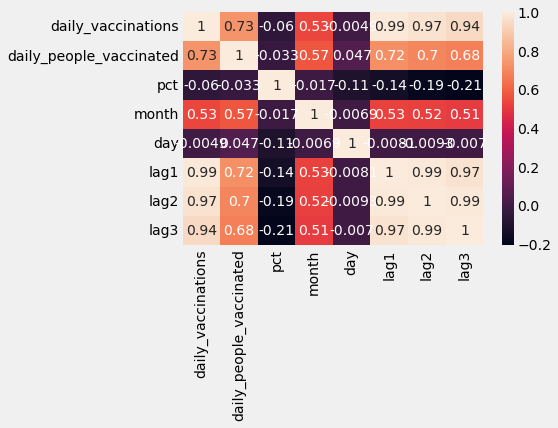

In [31]:
sns.heatmap(data.corr(), annot=True)

<AxesSubplot:xlabel='month', ylabel='daily_vaccinations'>

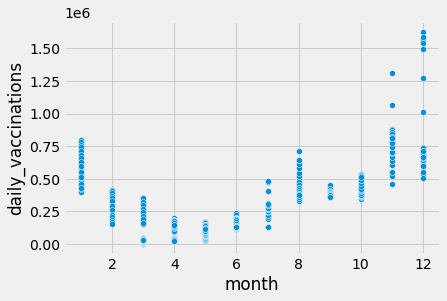

In [32]:
sns.scatterplot(data['month'], data['daily_vaccinations'])

<AxesSubplot:xlabel='daily_people_vaccinated', ylabel='daily_vaccinations'>

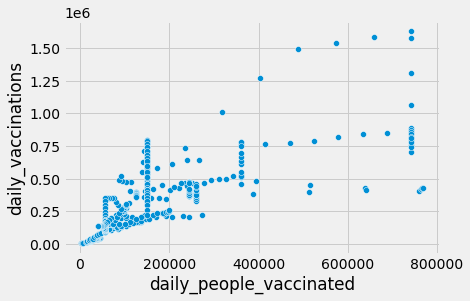

In [33]:
sns.scatterplot(data['daily_people_vaccinated'], data['daily_vaccinations'])

In [34]:
X = data[['daily_people_vaccinated', 'month', 'lag1', 'lag2', 'lag3']]
y = data['daily_vaccinations']

m_scaler = StandardScaler()
x_scaled = m_scaler.fit_transform(X)

In [35]:
lm = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
preds = []

for x in [lm, knn, dt]:
    x.fit(x_scaled, y)
    print(x.score(x_scaled, y))
    preds.append(x.predict(x_scaled))

0.9879742888234234
0.9786263071881041
0.9999859591987041


<AxesSubplot:xlabel='date', ylabel='daily_vaccinations'>

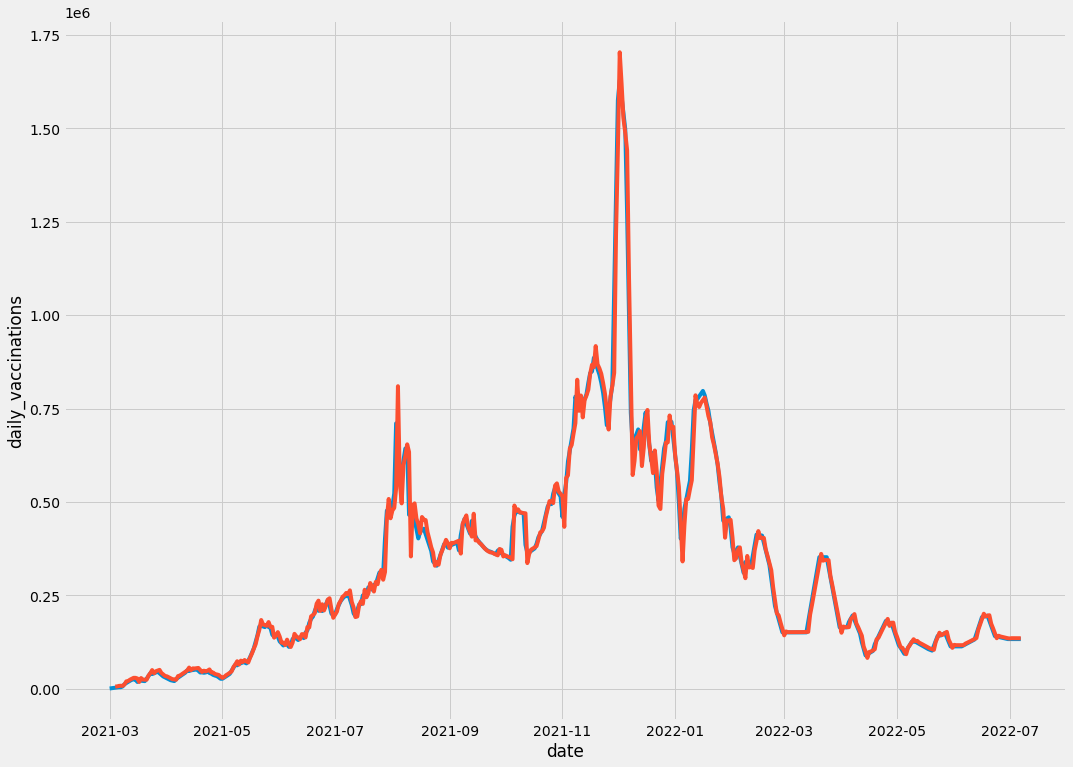

In [36]:
plt.figure(figsize=(16,12))
sns.lineplot(ph_df_clean.index, ph_df_clean.daily_vaccinations)
sns.lineplot(ph_df_clean.index[3:], preds[0])

<AxesSubplot:xlabel='date', ylabel='daily_vaccinations'>

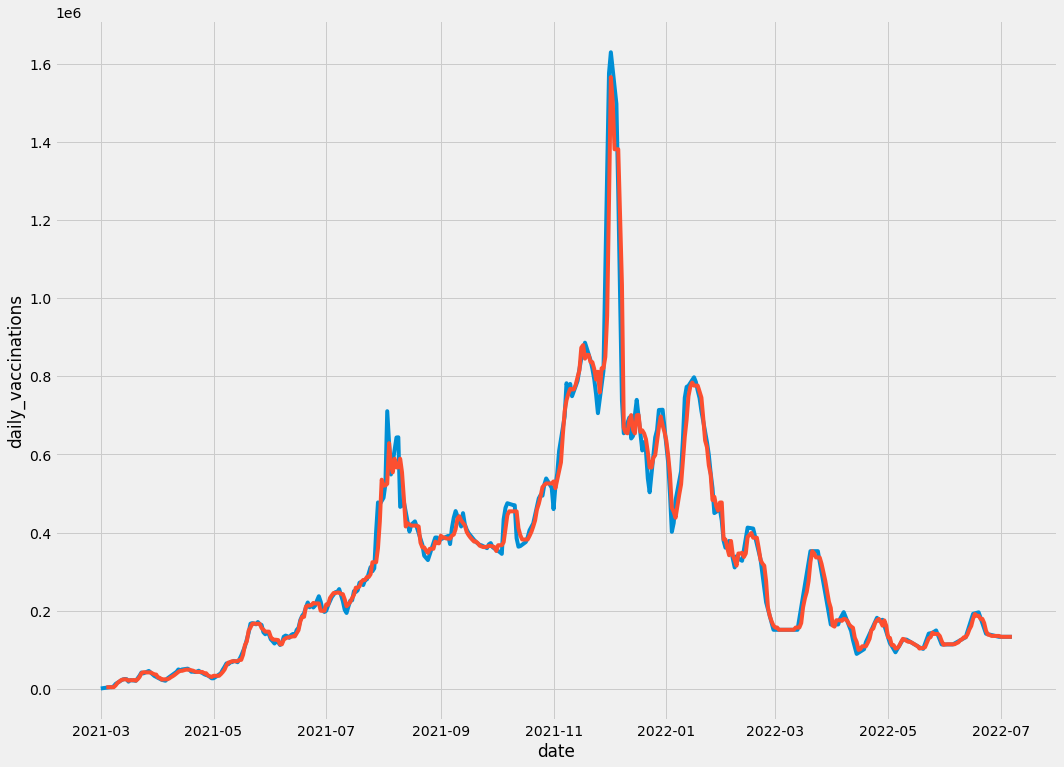

In [37]:
plt.figure(figsize=(16,12))
sns.lineplot(ph_df_clean.index, ph_df_clean.daily_vaccinations)
sns.lineplot(ph_df_clean.index[3:], preds[1])

<AxesSubplot:xlabel='date', ylabel='daily_vaccinations'>

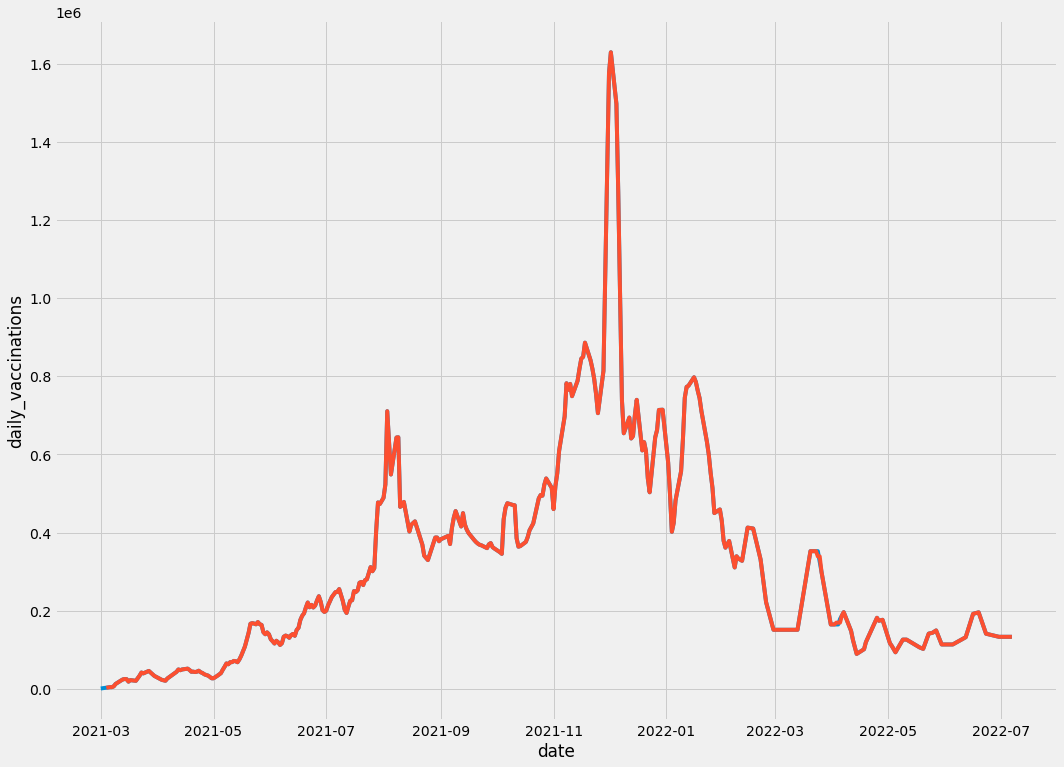

In [38]:
plt.figure(figsize=(16,12))
sns.lineplot(ph_df_clean.index, ph_df_clean.daily_vaccinations)
sns.lineplot(ph_df_clean.index[3:], preds[2])

# Auto Regression

In [39]:
def train_test(data, ts = 0.8):
    train_size =int(data.shape[0] * ts)
    return data[:train_size], data[train_size:]

train, test = train_test(ph_df_final)
train.shape, test.shape

((395,), (99,))

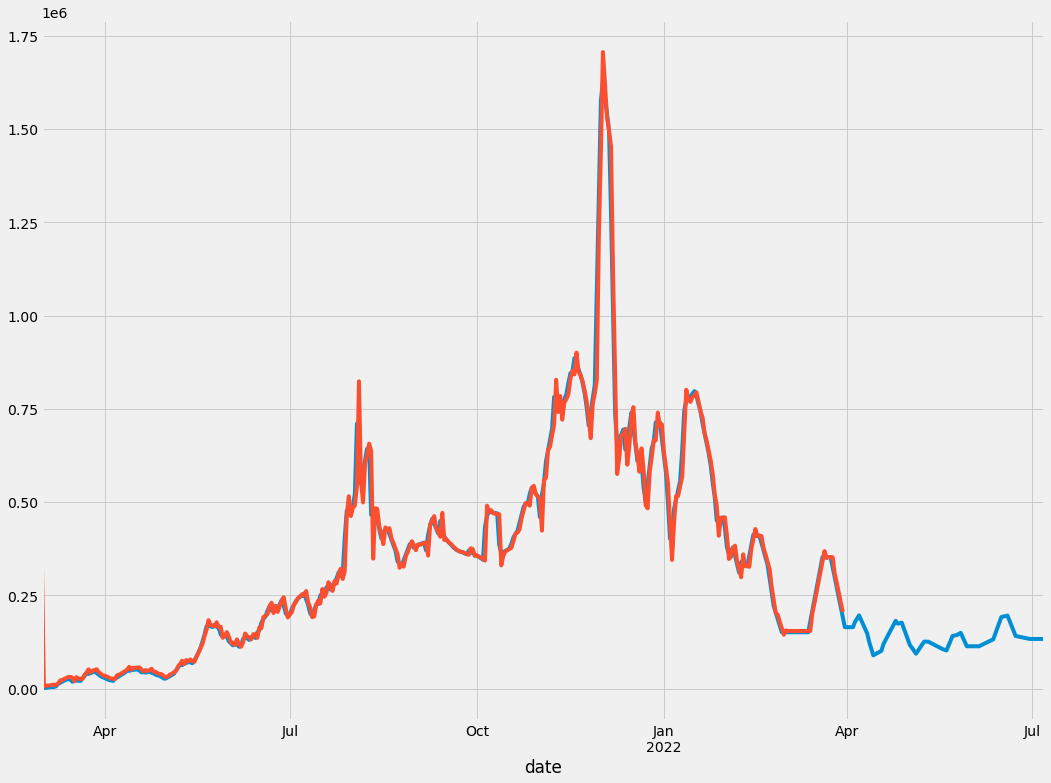

In [40]:
ar = ARIMA(train, order=(3,0,0)).fit()
ph_df_final.plot(figsize=(16,12), label='actual')
ar.fittedvalues.plot(label='predicted')
plt.show()

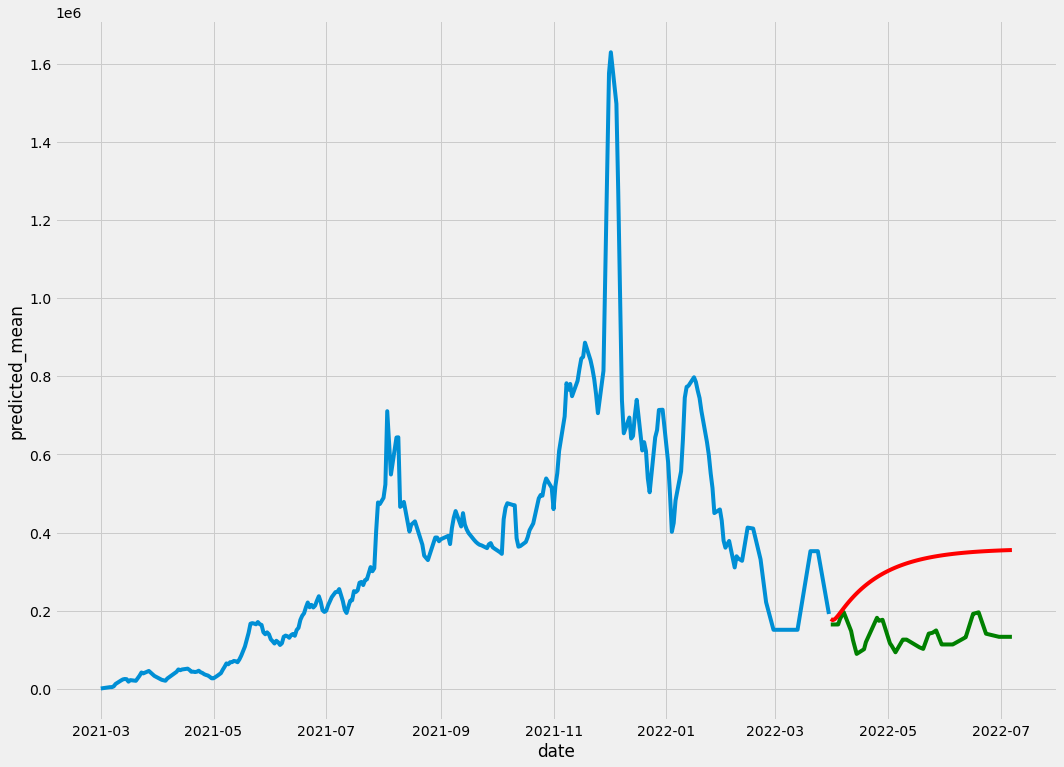

In [41]:
yhat = ar.forecast(len(test))

plt.figure(figsize=(16,12))
s = sns.lineplot(train.index, train.values)
sns.lineplot(test.index, test.values, color='g')
sns.lineplot(test.index, yhat, ax=s, color='r')

plt.show()

In [42]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     daily_vaccinations   No. Observations:                  395
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -4674.986
Date:                Fri, 02 Sep 2022   AIC                           9359.971
Time:                        01:34:02   BIC                           9379.866
Sample:                    03-01-2021   HQIC                          9367.854
                         - 03-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.588e+05    3.1e-09   1.16e+14      0.000    3.59e+05    3.59e+05
ar.L1          1.6329      0.022     74.237      0.000       1.590       1.676
ar.L2         -0.7271      0.049    -14.853      0.000      -0.823      -0.631
ar.L3          0.0778      0.030      2.581      0.010       0.019       0.137
sigma2      1.106e+09    3.2e-11   3.46e+19      0.000    1.11e+09    1.11e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4026.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              24.73   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+34. Standard errors may be unstable.
"""

In [43]:
print('train R2: ', r2_score(train, ar.fittedvalues))
print('train MAE: ', mean_absolute_error(train, ar.fittedvalues))

print('test R2: ', r2_score(test, ar.forecast(len(test))))
print('test MAE: ', mean_absolute_error(test, ar.forecast(len(test))))

train R2:  0.9820368916176871
train MAE:  17921.34049101277
test R2:  -44.471478018335645
test MAE:  171661.90864266627


# Moving Average

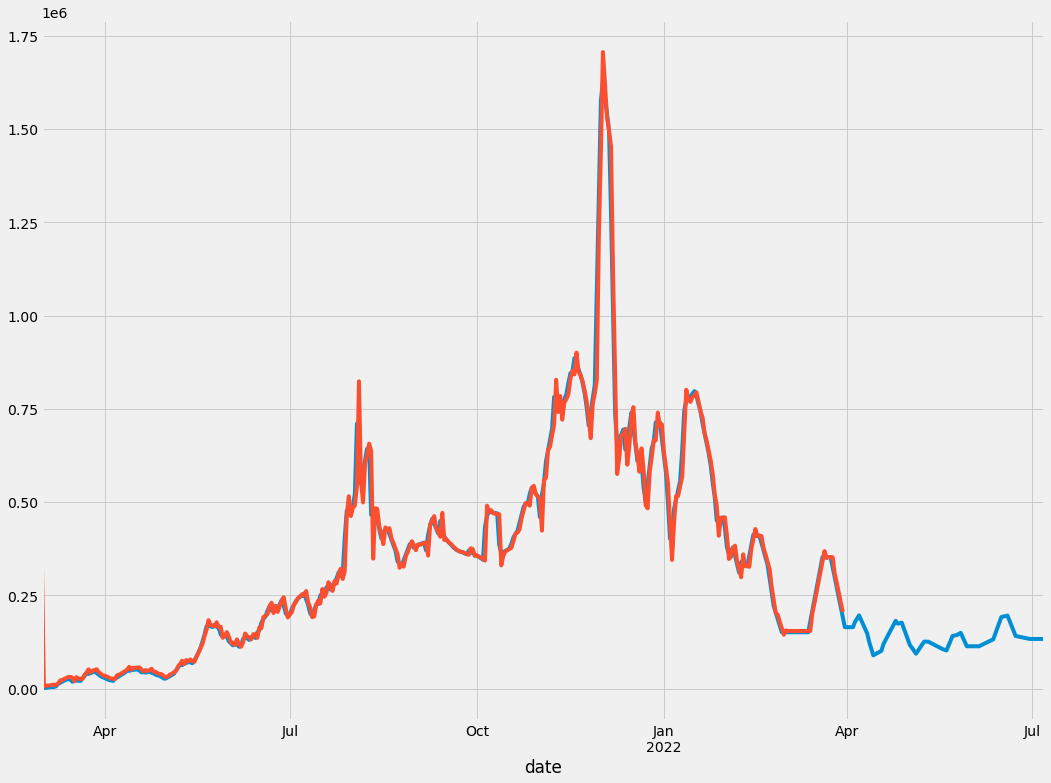

In [44]:
ma = ARIMA(train, order=(0,1,3)).fit()
ph_df_final.plot(figsize=(16,12))
ar.fittedvalues.plot()
plt.show()

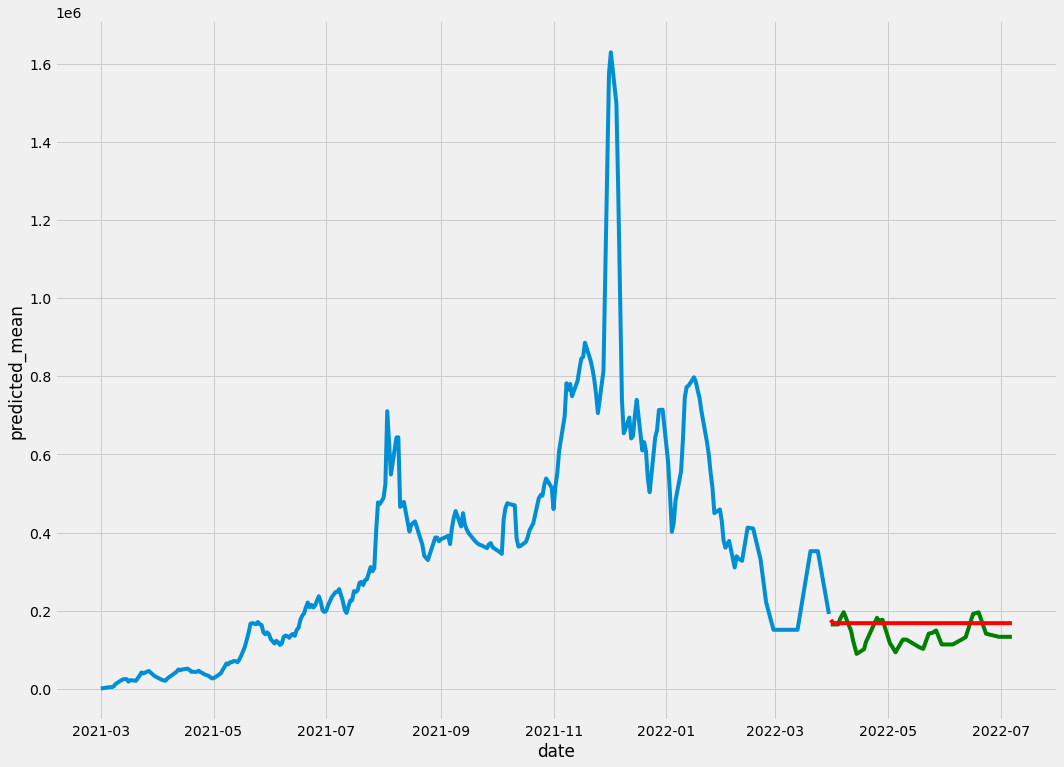

In [45]:
yhat = ma.forecast(len(test))

plt.figure(figsize=(16,12))
s = sns.lineplot(train.index, train.values)
sns.lineplot(test.index, test.values, color='g')
sns.lineplot(test.index, yhat, ax=s, color='r')

plt.show()

In [46]:
ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     daily_vaccinations   No. Observations:                  395
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -4666.057
Date:                Fri, 02 Sep 2022   AIC                           9340.114
Time:                        01:34:03   BIC                           9356.020
Sample:                    03-01-2021   HQIC                          9346.417
                         - 03-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6754      0.026     25.619      0.000       0.624       0.727
ma.L2          0.4331      0.030     14.329      0.000       0.374       0.492
ma.L3          0.1491      0.033      4.533      0.000       0.085       0.214
sigma2      1.352e+09   8.19e-12   1.65e+20      0.000    1.35e+09    1.35e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              4522.62
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              39.36   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [47]:
print('train R2: ', r2_score(train, ma.fittedvalues))
print('train MAE: ', mean_absolute_error(train, ma.fittedvalues))

print('test R2: ', r2_score(test, ma.forecast(len(test))))
print('test MAE: ', mean_absolute_error(test, ma.forecast(len(test))))

train R2:  0.9859898240219016
train MAE:  16598.90293565235
test R2:  -1.2767712663524704
test MAE:  35677.52286153238


# FIND BEST PARAMETER

In [48]:
from pmdarima.arima import auto_arima

In [49]:
auto_model=auto_arima(train,start_p=0,d=1,start_q=0, max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5, max_Q=5, m=12, seasonal=True, trace=True,
          supress_warnings=True,stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=9483.031, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(0,1,4)[12]             : AIC=inf, Time=4.18 sec
 ARIMA(0,1,0)(0,1,5)[12]             : AIC=9389.081, Time=10.02 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=9362.633, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(0,1,0)(1,1,4)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9337.167, Time=0.46 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=7.00 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=9326.7

In [50]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  395
Model:             SARIMAX(0, 1, 4)x(0, 1, [1], 12)   Log Likelihood               -4577.146
Date:                              Fri, 02 Sep 2022   AIC                           9166.292
Time:                                      01:37:33   BIC                           9189.964
Sample:                                           0   HQIC                          9175.683
                                              - 395                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6666      0.071      9.365      0.000       0.527       0.806
ma.L2          0.7068      0.080      8.842      0.000       0.550       0.863
ma.L3          0.0489      0.088      0.555      0.579      -0.124       0.222
ma.L4         -0.3607      0.068     -5.298      0.000      -0.494      -0.227
ma.S.L12      -0.8811      0.078    -11.280      0.000      -1.034      -0.728
sigma2      2.694e+09   1.44e-11   1.88e+20      0.000    2.69e+09    2.69e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3788.55
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              23.17   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+35. Standard errors may be unstable.
"""

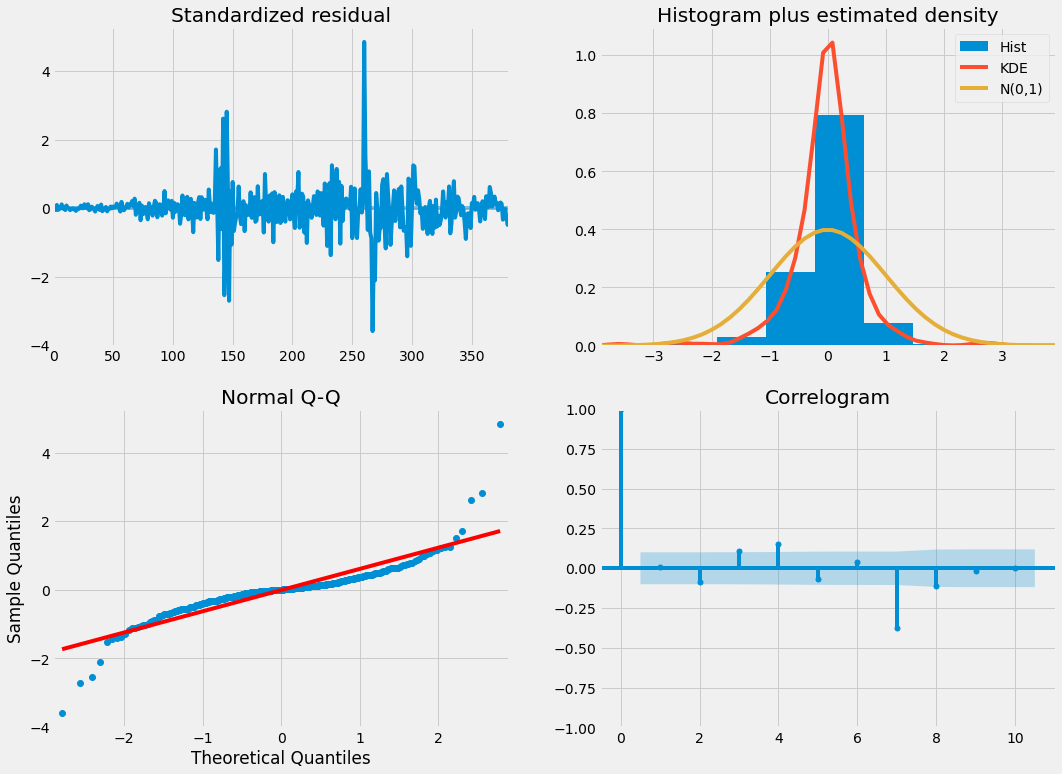

In [51]:
auto_model.plot_diagnostics(figsize=(16,12)).show()

<AxesSubplot:xlabel='date'>

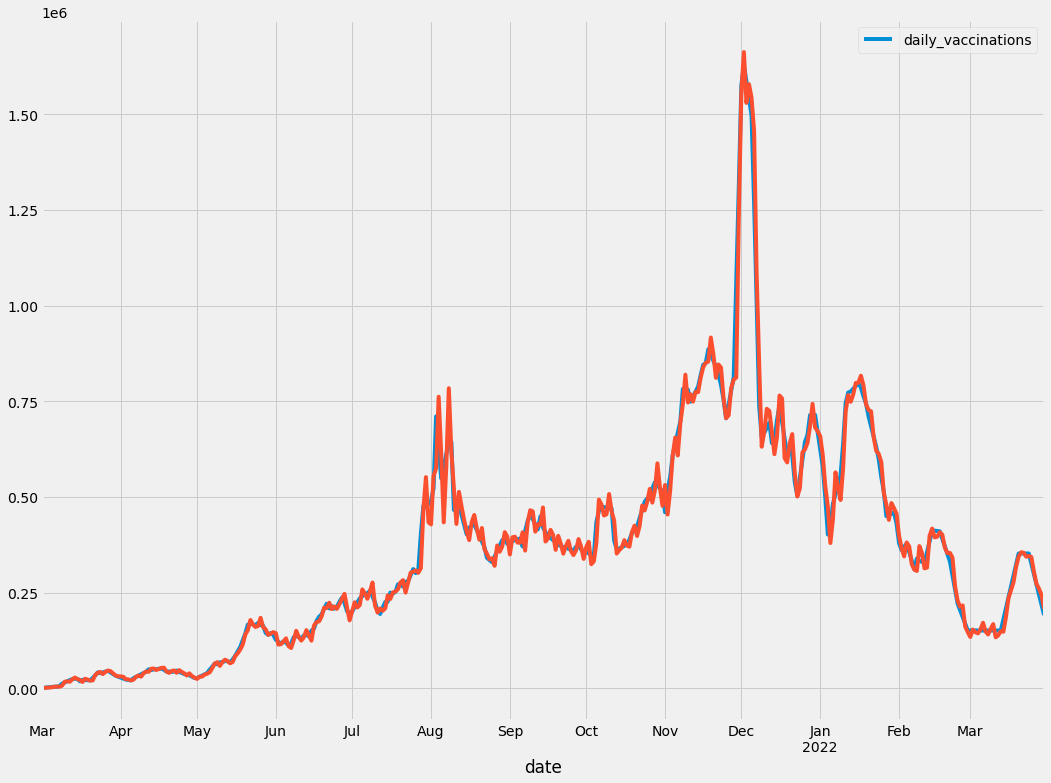

In [52]:
pred = auto_model.predict_in_sample()
train.plot(figsize=(16,12))
sns.lineplot(train.index, pred)

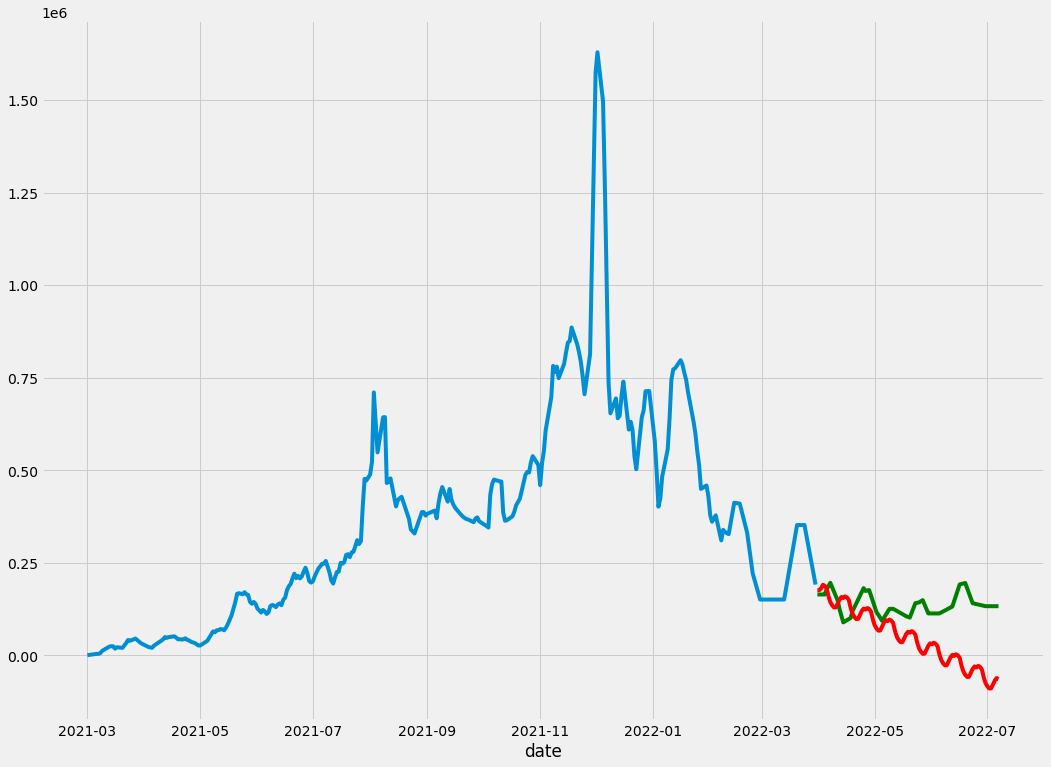

In [53]:
yhat = auto_model.predict(len(test))

plt.figure(figsize=(16,12))
s = sns.lineplot(train.index, train.values)
sns.lineplot(test.index, test.values, color='g')
sns.lineplot(test.index, yhat, ax=s, color='r')

plt.show()

In [54]:
print('train R2: ', r2_score(train, auto_model.predict_in_sample()))
print('train MAE: ', mean_absolute_error(train, auto_model.predict_in_sample()))

print('test R2: ', r2_score(test, auto_model.predict(len(test))))
print('test MAE: ', mean_absolute_error(test, auto_model.predict(len(test))))

train R2:  0.9874199724892452
train MAE:  18314.698168855597
test R2:  -18.17580314886817
test MAE:  96493.56560048685


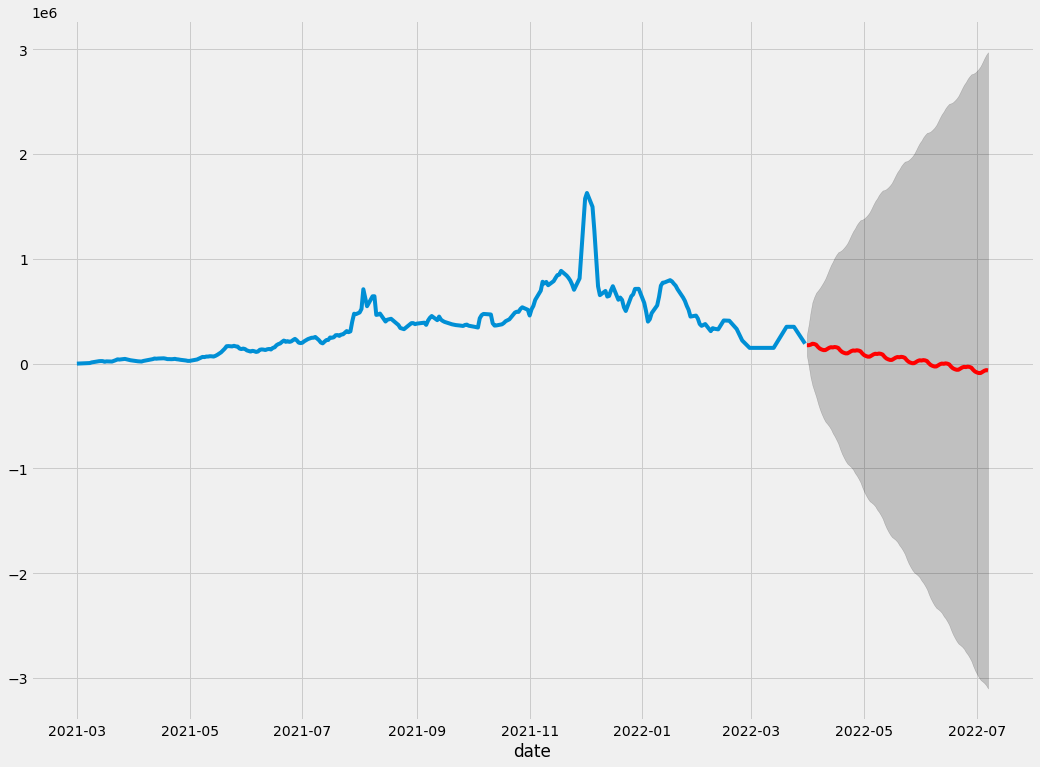

In [55]:
yhat, conf_int = auto_model.predict(len(test), return_conf_int=True)

plt.figure(figsize=(16,12))
s = sns.lineplot(train.index, train.values)
sns.lineplot(test.index, yhat, ax=s, color='r')

plt.fill_between(test.index, conf_int.T[0], conf_int.T[1], 
                color='k', alpha=0.2)

plt.show()

# FB Prophet

In [56]:
from prophet import Prophet

In [57]:
train

date
2021-03-01       756.0
2021-03-02      1396.0
2021-03-03      2132.0
2021-03-04      2500.0
2021-03-05      3514.0
                ...   
2022-03-26    298608.0
2022-03-27    271807.0
2022-03-28    245006.0
2022-03-29    218204.0
2022-03-30    191403.0
Name: daily_vaccinations, Length: 395, dtype: float64

In [58]:
train_prop = pd.DataFrame()

train_prop['ds'] = train.index
train_prop['y'] = train.values
train_prop

ds         y
0   2021-03-01     756.0
1   2021-03-02    1396.0
2   2021-03-03    2132.0
3   2021-03-04    2500.0
4   2021-03-05    3514.0
..         ...       ...
390 2022-03-26  298608.0
391 2022-03-27  271807.0
392 2022-03-28  245006.0
393 2022-03-29  218204.0
394 2022-03-30  191403.0

[395 rows x 2 columns]

In [59]:
fbprop = Prophet()

fbprop.fit(train_prop)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [60]:
labels_fb = fbprop.make_future_dataframe(100)
labels_fb

ds
0   2021-03-01
1   2021-03-02
2   2021-03-03
3   2021-03-04
4   2021-03-05
..         ...
490 2022-07-04
491 2022-07-05
492 2022-07-06
493 2022-07-07
494 2022-07-08

[495 rows x 1 columns]

In [61]:
forecast = fbprop.predict(labels_fb)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds           yhat     yhat_lower     yhat_upper
0   2021-03-01  -64237.230980 -251884.945034  109945.168133
1   2021-03-02  -61879.245704 -234585.105228  122740.172490
2   2021-03-03  -59514.142496 -228568.771610  126546.144978
3   2021-03-04  -57181.903846 -231138.601737  125400.383629
4   2021-03-05  -54866.126610 -239084.172662  132299.245306
..         ...            ...            ...            ...
490 2022-07-04 -348386.352728 -569436.909729 -139517.312701
491 2022-07-05 -353942.272479 -553059.141753 -145987.889956
492 2022-07-06 -359491.074298 -575002.214348 -146579.609323
493 2022-07-07 -365072.740676 -575855.031183 -148627.673330
494 2022-07-08 -370670.868468 -567677.023473 -158841.675668

[495 rows x 4 columns]

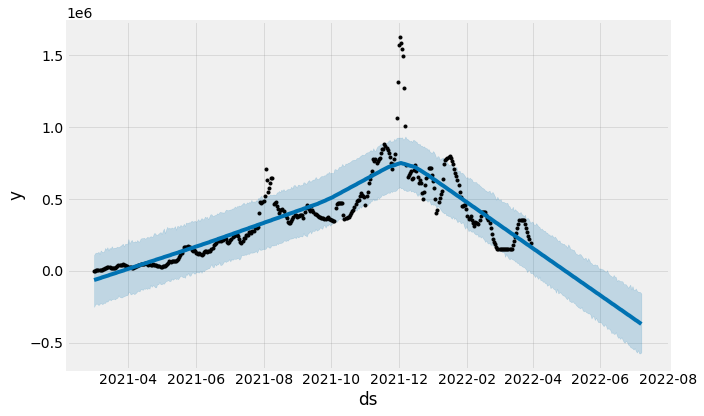

In [62]:
fbprop.plot(forecast).show()

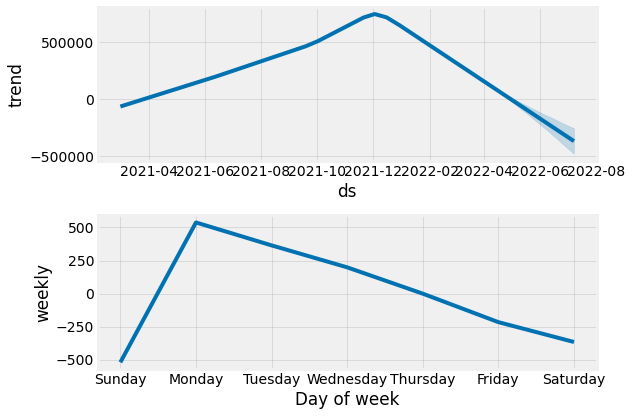

In [63]:
fbprop.plot_components(forecast).show()

In [64]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(fbprop, forecast)

# LSTM

In [65]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))
train_scaled.shape, test_scaled.shape

((395, 1), (99, 1))

In [67]:
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=8)
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=8)
X,y = train_generator[2]
X.shape, y.shape

((128, 8, 1), (128, 1))

In [68]:
model = Sequential()

model.add(LSTM(100, activation='tanh', input_shape=(8, 1), return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


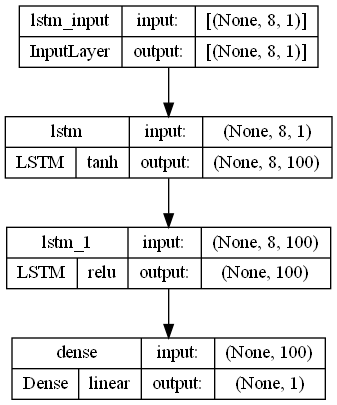

In [69]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [70]:
model.fit(train_generator, epochs=100, batch_size=32, validation_data=test_generator)

Epoch 1/100
4/4 [==============================] - 4s 253ms/step - loss: 0.9675 - val_loss: 0.4584
Epoch 2/100
4/4 [==============================] - 0s 29ms/step - loss: 0.7400 - val_loss: 0.3374
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.6446 - val_loss: 0.1740
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 0.4291 - val_loss: 0.0302
Epoch 5/100
4/4 [==============================] - 0s 33ms/step - loss: 0.2579 - val_loss: 0.0518
Epoch 6/100
4/4 [==============================] - 0s 28ms/step - loss: 0.4296 - val_loss: 0.1035
Epoch 7/100
4/4 [==============================] - 0s 30ms/step - loss: 0.3054 - val_loss: 0.0123
Epoch 8/100
4/4 [==============================] - 0s 28ms/step - loss: 0.2425 - val_loss: 0.0444
Epoch 9/100
4/4 [==============================] - 0s 27ms/step - loss: 0.2567 - val_loss: 0.0519
Epoch 10/100
4/4 [==============================] - 0s 28ms/step - loss: 0.2523 - val_loss: 0.0417
Epoch 11/100
4/4 [

Epoch 84/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0439 - val_loss: 0.0069
Epoch 85/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0527 - val_loss: 0.0183
Epoch 86/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0395 - val_loss: 0.0205
Epoch 87/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0573 - val_loss: 0.0081
Epoch 88/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0414 - val_loss: 0.0235
Epoch 89/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0486 - val_loss: 0.0053
Epoch 90/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0345 - val_loss: 0.0134
Epoch 91/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0348 - val_loss: 0.0085
Epoch 92/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0322 - val_loss: 0.0050
Epoch 93/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0333 - val_loss: 0.0056
Epoch 94/1

4/4 [==============================] - 1s 7ms/step


<AxesSubplot:xlabel='date'>

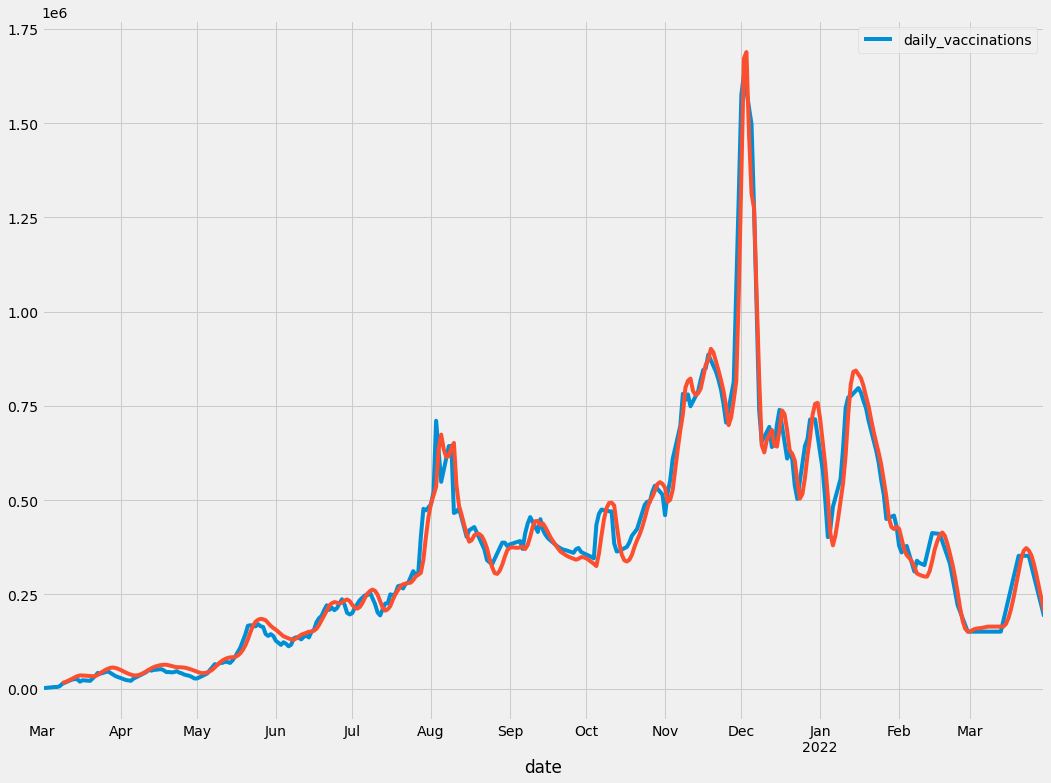

In [71]:
train_predictions = model.predict(train_generator)
train_original_prediction = scaler.inverse_transform(train_predictions)
train.plot(figsize=(16,12))
sns.lineplot(train.index[8:], train_original_prediction.flatten())

In [72]:
#Recursive Forecasting

def forecast(model, n, data):
    data = data.flatten()
    preds = np.array([])
    for x in range(n):
        topred = data[-8:].reshape(1,8,1)
        pred = model.predict(topred, verbose=0)[0]
        preds = np.concatenate((preds, pred), axis=0)
        data = np.concatenate((data, pred), axis=0)
    
    return preds.flatten()

<AxesSubplot:xlabel='date'>

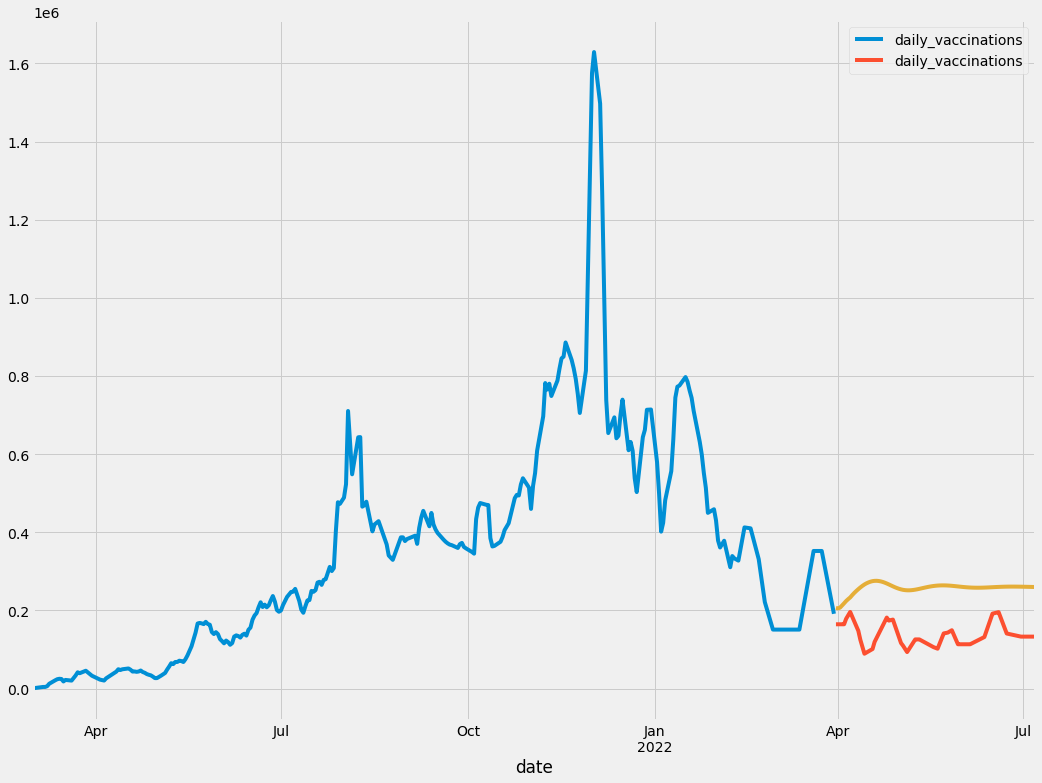

In [73]:
pred = forecast(model, len(test), train_generator[0][0])
test_original_prediction = scaler.inverse_transform(pred.reshape(-1,1))

ax = train.plot(figsize=(16,12))
test.plot(figsize=(16,12))
sns.lineplot(test.index, test_original_prediction.flatten(), ax=ax)

<AxesSubplot:xlabel='date'>

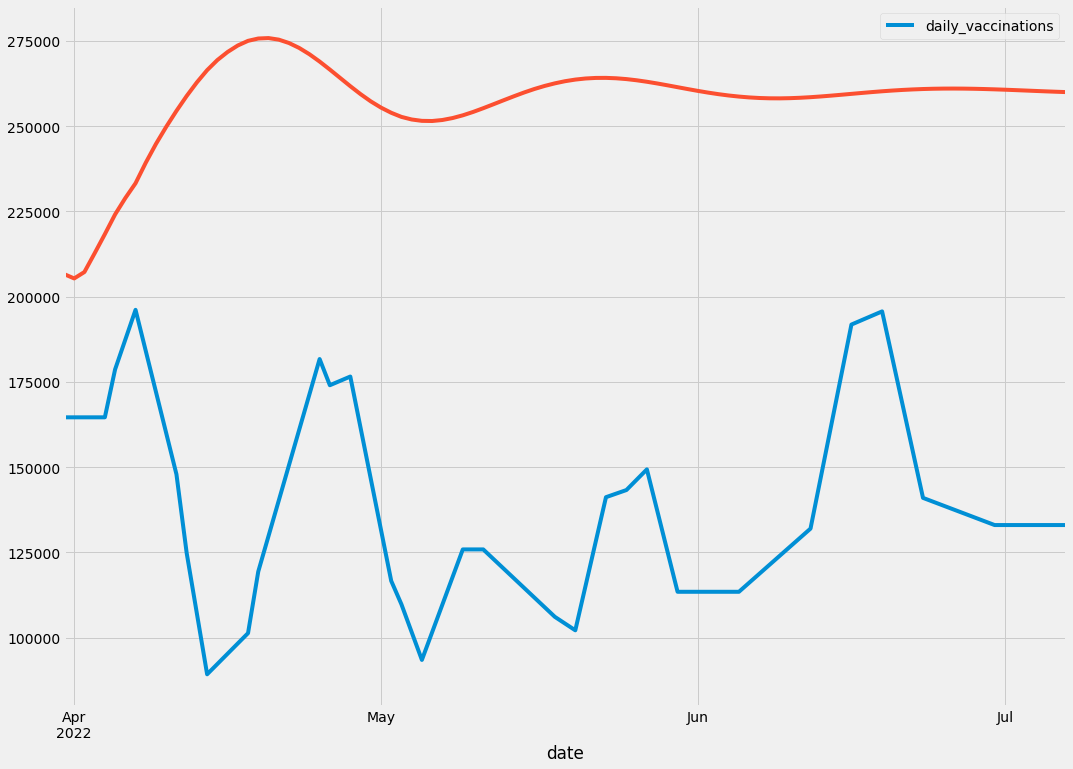

In [74]:
test.plot(figsize=(16,12))
sns.lineplot(test.index, test_original_prediction.flatten())

3/3 [==============================] - 0s 5ms/step


<AxesSubplot:xlabel='date'>

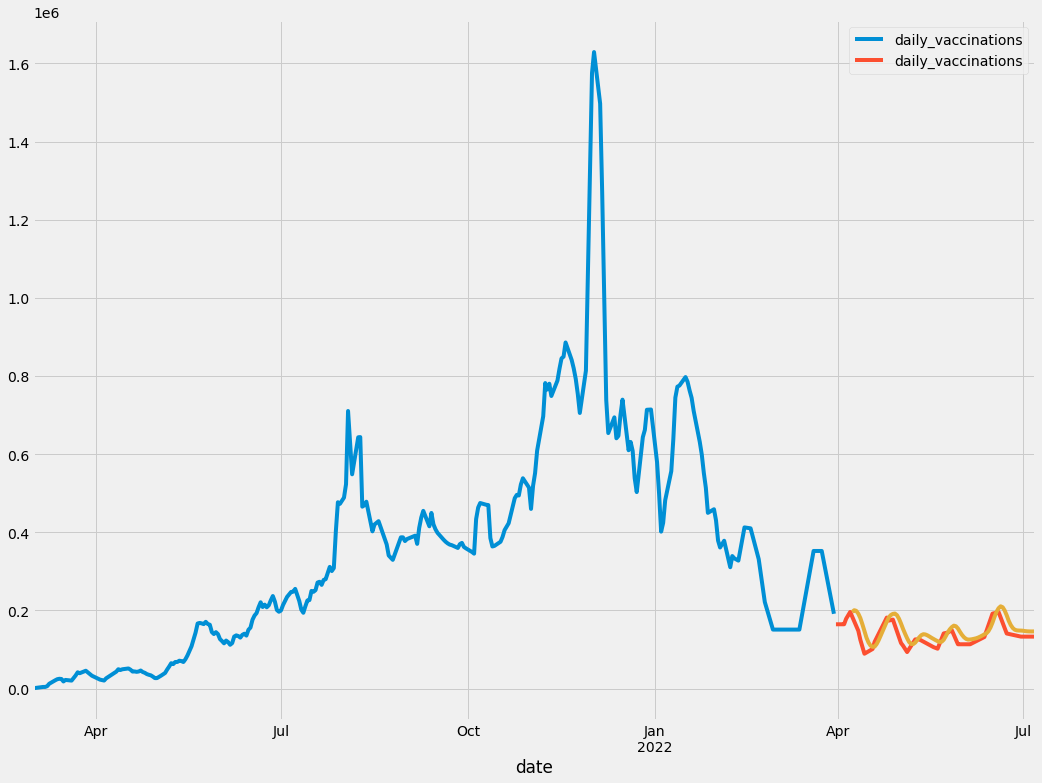

In [75]:
data, val = test_generator[0]
test_predictions = model.predict(data)
test_original_prediction = scaler.inverse_transform(test_predictions)

ax = train.plot(figsize=(16,12))
test.plot(figsize=(16,12))
sns.lineplot(test.index[8:], test_original_prediction.flatten(), ax=ax)

<AxesSubplot:xlabel='date'>

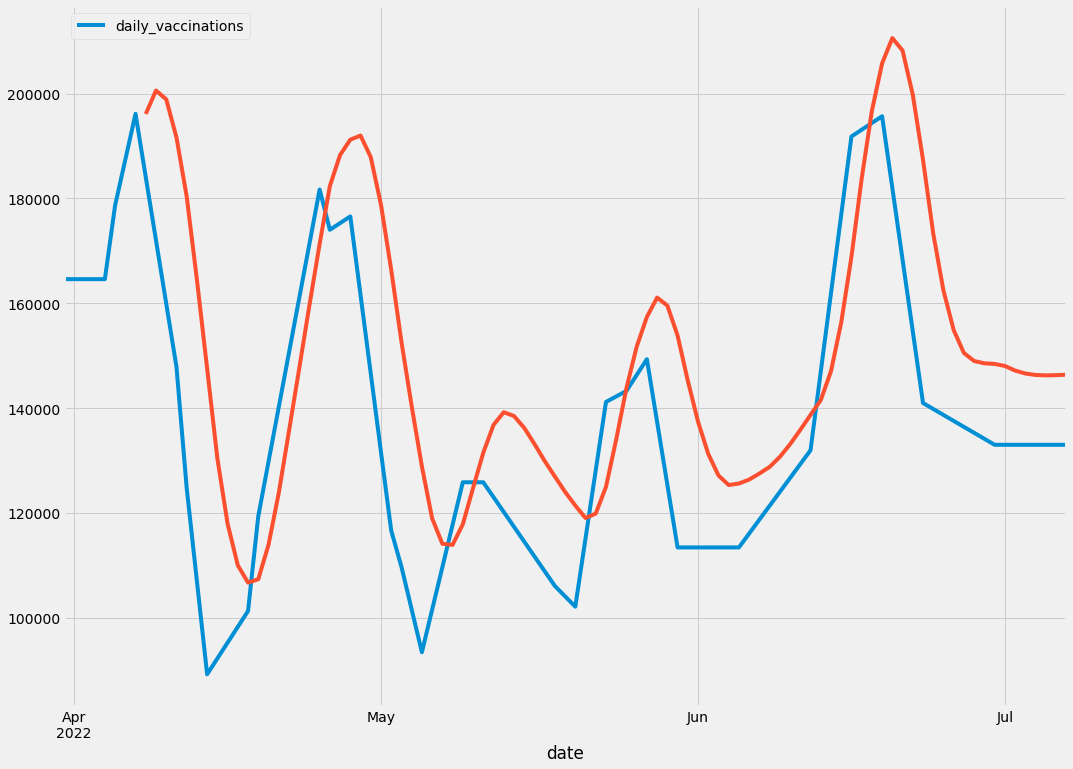

In [76]:
test.plot(figsize=(16,12))
sns.lineplot(test.index[8:], test_original_prediction.flatten())

In [77]:
print('train R2: ', r2_score(train.values[8:], train_original_prediction))
print('train MAE: ', mean_absolute_error(train.values[8:], train_original_prediction))
print('test R2: ', r2_score(test.values[8:], test_original_prediction))
print('test MAE: ', mean_absolute_error(test.values[8:], test_original_prediction))

train R2:  0.9746936769568266
train MAE:  28903.903173954295
test R2:  0.12952752070362494
test MAE:  19723.548763736264
